<a href="https://colab.research.google.com/github/delffine/Pet-projects/blob/main/bike_train_duration/veloopros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import numpy as np
import scipy.stats as stats
from matplotlib.colors import TwoSlopeNorm

In [2]:
pd.options.display.max_colwidth = 9000

# Процедуры и функции

In [3]:
#Цвет RGB в HEX
def rgba2hex(rgba):
    r = int(rgba[0] * 255)
    g = int(rgba[1] * 255)
    b = int(rgba[2] * 255)
    return f'#{r:02x}{g:02x}{b:02x}'


In [4]:
#Список градиентов цвета в зависимости от входной величины
def gradient_by_value(col = pd.Series([]), gradient = plt.cm.RdYlGn_r):
    norm = TwoSlopeNorm(vmin=col.min(), vcenter=col.mean(), vmax=col.max())
    colors = [rgba2hex(gradient(norm(c))) for c in col]
    return colors

In [5]:
# Вывод проверки выброк для тестирования
def chek_dd_test(d_test1, d_test2):
  norm1 = False
  norm2 = False
  pval = stats.normaltest(d_test1)[1]
  if pval < 0.05:
     print(f'Первая выборка размером {len(d_test1)} НЕ прошла проверку на нормальное распределение. pval = {pval}')
  else:
      print(f'Первая выборка размером {len(d_test1)} прошла проверку на нормальное распределение. pval = {pval}')
      norm1 = True

  pval = stats.normaltest(d_test2)[1]
  if pval < 0.05:
      print(f'Вторая выборка размером {len(d_test2)} НЕ прошла проверку на нормальное распределение. pval = {pval}')
  else:
      print(f'Вторая выборка размером {len(d_test2)} прошла проверку на нормальное распределение. pval = {pval}')
      norm2 = True

  equal_var = False
  pval = stats.levene(d_test1, d_test2)[1]
  if pval < 0.05:
      print(f'Дисперсии выборок НЕ близки. pval = {pval}. Применяем equal_var=False')
  else:
      print(f'Дисперсии выборок близки. pval = {pval}. Применяем equal_var=True ')
      equal_var = True
  return norm1, norm2, equal_var

In [6]:
# Вывод результатов тестирования в зависимост от pvalue
def pval_print (pval, h0='', h1=''):
    print('В результате теста получено p-value', pval)
    if pval < 0.05:
        print('НЕ можем принять нулевую гипотезу, принимаем альтернативную:')
        print(' ------> \033[31m\033[1m', h1, '\033[0m')
    else:
        print('НЕ можем отвегнуть нулевую гипотезу, принимаем ее:')
        print(' ------> \033[32m\033[1m', h0, '\033[0m')

In [7]:
# Тестирование сравнения двух выборок
def test_selection (d_test1, d_test2, side='two-sided', h0='', h1=''):
  norm1, norm2, e_var = chek_dd_test(d_test1, d_test2)
  l1 = (len(d_test1) > 30)
  l2 = (len(d_test2) > 30)
  print()
  if (norm1 & norm2): print('Обе выборки имеют нормальное распределение!')
  if ((l1 or norm1) and (l2 or norm2)) :
    if (l1 & l2): print(f'Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest')
    print()
    print('--- Проводим TTest ---')
    pval = stats.ttest_ind(d_test1, d_test2, alternative = side, equal_var=e_var)[1]
    pval_print(pval, h0, h1)
    print()
    print('Для сравнения проведем и параметрический тест Манна-Уитни')
    print()
  else:
    print(f'Выборки маленькие ({len(d_test2)} / {len(d_test2)}) - НЕЛЬЗЯ применять ttest')

  print('---- Проводим Test Mann-Whitneyu ----')
  pval = stats.mannwhitneyu(d_test1, d_test2, alternative = side)[1]
  pval_print(pval, h0, h1)

# Загрузка данных

In [8]:
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/dtp/'):
  from google.colab import drive
  drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/bike_duration/

/content/drive/My Drive/Colab Notebooks/bike_duration


In [9]:
data = pd.read_excel('bike_train_duration.xlsx')

In [10]:
#data = pd.read_csv('d:/swim run bike/trisystems/velo-opros.csv')

In [11]:
data.head()

,Timestamp,Ваш вес,Ваш пол,Ваш вид спорта,"Какой у вас средний тренировочный объем велотренировок в неделю в часах за последний год (укажите, пожалуйста, в формате чч:мм:сс)","Если знаете, то укажите какой у вас средний тренировочный объем в неделю в часах за последний год по другим активности вместе взятым (силовые, бег, плавание и тд, в формате чч:мм:сс)",Сколько месяцев или лет (уточните в ответе) у вас общий тренировочный стаж в тренировках по велосипеду? Если был значительный перерыв в тренировках также напишите про это.,"Какой у вас наивысший уровень анаэробного порога (часовой мощности или ФТП) в этом сезоне? Укажите цифру по мощности (например, 210)",Каким способом вы определили ваш пиковый анаэробный порог (ФТП) в сезоне?
0,2024-12-26 12:06:12.754,1,Женский,Триатлон,1,1,1,1,По результатом полевых тестирований
1,2024-12-26 12:58:01.835,73,Мужской,Триатлон,6:00:00,11:00:00,4 года,285,По результатом полевых тестирований
2,2024-12-26 12:59:07.121,73,Мужской,Велоспорт,13:16:25,NaN,4,320,Расчетным путем исходя их результатов гонок
3,2024-12-26 13:00:24.132,73,Мужской,Триатлон,05:43:57,10:49:50,5 лет,215,Из результатов лабораторного тестирования
4,2024-12-26 13:00:38.202,"82,0",Мужской,Триатлон,4:30:00,8:30:00,2года,215,Seift


In [12]:
data.columns = ('date_answer' , 'weigth', 'gender', 'sport', 'bike_hours', 'train_hours', 'train_stag', 'ftp', 'ftp_source')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_answer  157 non-null    datetime64[ns]
 1   weigth       157 non-null    object        
 2   gender       157 non-null    object        
 3   sport        157 non-null    object        
 4   bike_hours   157 non-null    object        
 5   train_hours  108 non-null    object        
 6   train_stag   157 non-null    object        
 7   ftp          157 non-null    object        
 8   ftp_source   157 non-null    object        
dtypes: datetime64[ns](1), object(8)
memory usage: 11.2+ KB


# Преобработка данных

## Категориальные данные

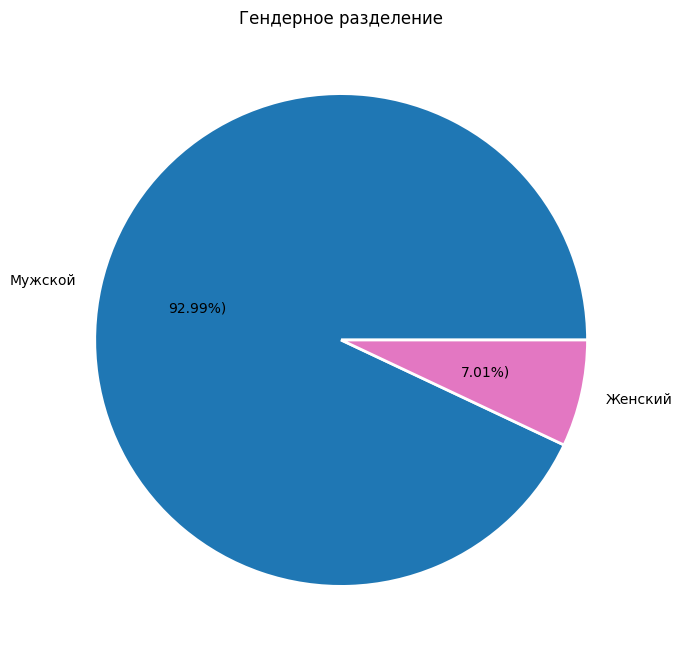

In [14]:
dd = data['gender'].value_counts()

fig = plt.figure(figsize = (15, 8))
plt.pie(x = dd, labels = dd.index, colors = ['tab:blue', 'tab:pink', 'yellow'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Гендерное разделение')
plt.show()

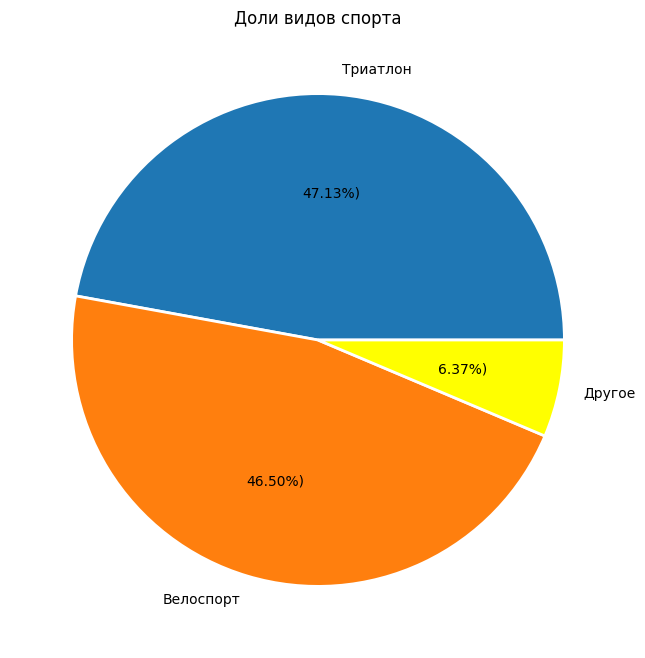

In [15]:
dd = data['sport'].apply(lambda x: 'Другое' if x not in ('Триатлон', 'Велоспорт') else x).value_counts()

fig = plt.figure(figsize = (15, 8))
plt.pie(x = dd, labels = dd.index, colors = ['tab:blue', 'tab:orange', 'yellow'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Доли видов спорта')
plt.show()



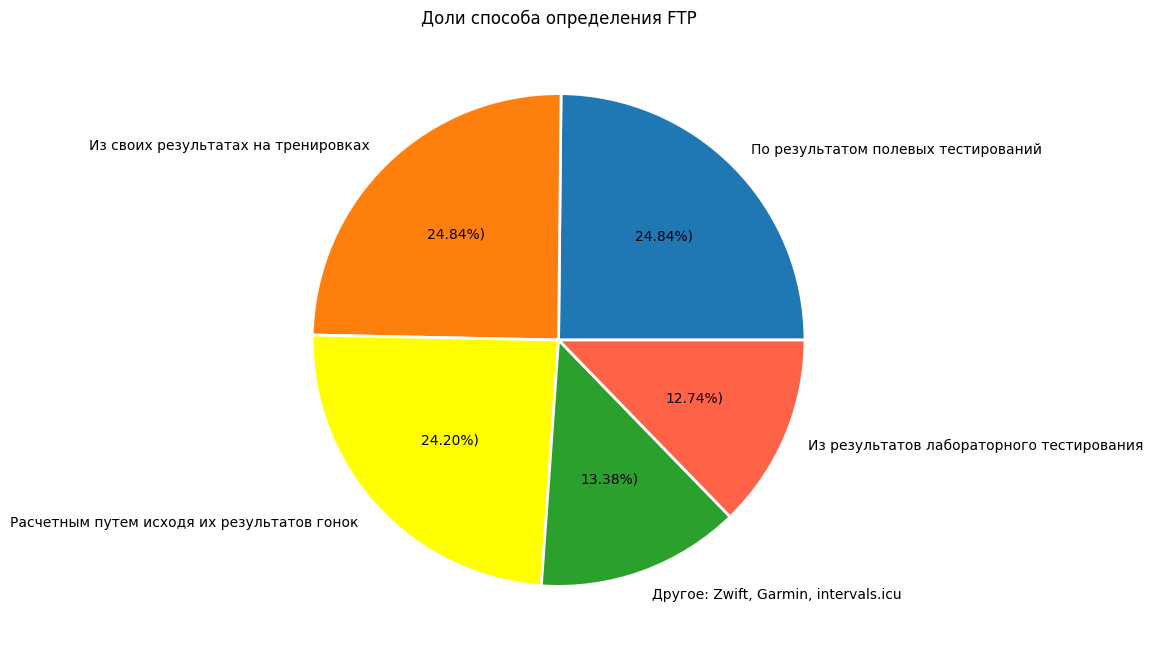

In [16]:
dd = data['ftp_source'].apply(lambda x: 'Другое: Zwift, Garmin, intervals.icu' if x not in (
    'По результатом полевых тестирований',
    'Из своих результатах на тренировках',
    'Расчетным путем исходя их результатов гонок',
    'Из результатов лабораторного тестирования',
    ) else x).value_counts()

fig = plt.figure(figsize = (15, 8))
plt.pie(x = dd, labels = dd.index, colors = ['tab:blue', 'tab:orange', 'yellow', 'tab:green', 'tomato'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Доли способа определения FTP')
plt.show()

## Числовые данные

Преобразуем исходные данные к удобоваримому виду

In [17]:
for i in range(0, len(data)):
# ------------- велотренировки ---------------------------
    bh = str(data.loc[i, 'bike_hours'])
    if bh != bh: bh = '0'
    bh = bh.replace(',', '.')
    bh = bh.replace('-', ':')
    bh = re.sub(r'[^0-9.:]+', '', bh)
    digits = []
    digits.append(re.split(':', bh))
    try:
        minuts = float(digits[-1][0]) * 60 + float(digits[-1][1])
    except:
        try:
            minuts = float(digits[-1][0]) * 60
        except:
            minuts = 0
    data.loc[i, 'bike_minute'] = minuts

# -------------- остальные тренировки -----------------------------
    th = str(data.loc[i, 'train_hours'])
    if th != th: th = '0'
    th = th.replace(',', '.')
    th = th.replace('-', ':')
    th = re.sub(r'[^0-9.:]+', '', th)
    digits = []
    digits.append(re.split(':', th))
    try:
        minuts = float(digits[-1][0]) * 60 + float(digits[-1][1])
    except:
        try:
            minuts = float(digits[-1][0]) * 60
        except:
            minuts = 0
    data.loc[i, 'train_minute'] = minuts

# ------------ Стаж. Каша в данных ---------------------
#    st = str(data.loc[i, 'train_stag'])
#    if st != st: st = '0'
#
#    st = re.sub(r'[^0-9.:]+', '', st)
#    try:
#        stag = float(st)
#    except:
#        stag = 0
#    data.loc[i, 'stag_c'] = stag
#
# ------------ вес ----------------------------------
    wg = str(data.loc[i, 'weigth'])
    if wg != wg: wg = '0'
    wg = wg.replace(',', '.')
    wg = re.sub(r'[^0-9.:]+', '', wg)
    try:
        weigth = float(wg)
    except:
        weigth = 0
    data.loc[i, 'weigth_c'] = weigth


# ----------- FTP  ---------------------------------
    ftp = str(data.loc[i, 'ftp'])
    if ftp != ftp: ftp = '0'

    ftp = re.sub(r'[^0-9.:]+', '', ftp)
    try:
        ftpf = float(ftp)
    except:
        ftpf = 0
    data.loc[i, 'ftp_c'] = ftpf


Проверяем аномалии по колонкам

вес

In [18]:
data.query('weigth_c < 50 | weigth_c > 150')

,date_answer,weigth,gender,sport,bike_hours,train_hours,train_stag,ftp,ftp_source,bike_minute,train_minute,weigth_c,ftp_c
0,2024-12-26 12:06:12.754,1,Женский,Триатлон,1,1,1,1,По результатом полевых тестирований,60.0,60.0,1.0,1.0
142,2024-12-27 09:32:22.672,67-68кг,Мужской,Велоспорт,14:10:04,NaN,7лет,310,По результатом полевых тестирований,850.0,0.0,6768.0,310.0


In [19]:
data.loc[142, 'weigth_c'] = 67

In [20]:
data = data.drop(index = 0)

FTP

In [21]:
data.query('ftp_c < 100 | ftp_c > 1000')[['date_answer', 'gender', 'sport', 'bike_hours']]

,date_answer,gender,sport,bike_hours
29,2024-12-26 13:11:01.266,Мужской,Велоспорт,7:37:13
31,2024-12-26 13:11:36.110,Мужской,"Трек, спринт.",7:45:38
80,2024-12-26 14:07:03.964,Мужской,Триатлон,05:04:39
118,2024-12-26 20:05:34.505,Женский,Бег,07:00:00


In [22]:
data.loc[29, 'ftp_c'] = 303.0
data.loc[80, 'ftp_c'] = 248.0

In [23]:
data = data.drop(index = 31)
data = data.drop(index = 118)

In [24]:
data['ftp_weigth'] = data['ftp_c'] / data['weigth_c']

Длительность вело тренировок

In [25]:
data.query('bike_minute < 30 | bike_minute > 1000')[['date_answer', 'gender', 'sport', 'bike_hours']]

,date_answer,gender,sport,bike_hours
91,2024-12-26 14:46:19.795,Мужской,Велоспорт,826:38:53
106,2024-12-26 17:00:06.644,Мужской,Триатлон,1.17.00
130,2024-12-26 23:08:40.061,Мужской,Велоспорт,10.56.51


In [26]:
data.loc[91, 'bike_minute'] = 15 * 60           # указано 826:38:53 - допустим, это годовой объем
data.loc[106, 'bike_minute'] = 1 * 60 + 17
data.loc[130, 'bike_minute'] = 10 * 60 + 56

Длительность других тренирово

In [27]:
data.query('train_minute > 1000')[['date_answer', 'gender', 'sport', 'train_hours']]

,date_answer,gender,sport,train_hours
26,2024-12-26 13:10:32.094,Мужской,Велоспорт,500
67,2024-12-26 13:49:42.612,Мужской,Велоспорт,Силовые тренировки в межсезонье в 2024 году. 3-4 часа в неделю
136,2024-12-27 04:21:04.022,Мужской,Велоспорт,34:50
144,2024-12-27 10:15:49.044,Мужской,Велоспорт,6 часов 30 минут


In [28]:
data.loc[67]['train_hours']

'Силовые тренировки в межсезонье в 2024 году. 3-4 часа в неделю'

In [29]:
data.loc[26, 'train_minute'] = 9.6 * 60   #указано 500, пускай это часов в год
data.loc[67, 'train_minute'] = 3.5 * 60
data.loc[136, 'train_minute'] = 0         #укзано 34:50 - хз как интерпретировать
data.loc[144, 'train_minute'] = 6.5 * 60

In [30]:
data.query('train_minute > 0 & train_minute < 30')[['date_answer', 'gender', 'sport', 'train_hours']]

,date_answer,gender,sport,train_hours
126,2024-12-26 22:08:12.788,Мужской,Велоспорт,00:13:30
141,2024-12-27 09:14:37.500,Мужской,Велоспорт,00:15:00


In [31]:
data = data.reset_index(drop = True)

# Исследовательский анализ

## Статистические харакретистики показателей

In [32]:
train_stat = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
train_stat.loc['Вело тренировки'] = data['bike_minute'].describe()
train_stat.loc['Другие тренировки'] = data['train_minute'].describe()
train_stat.loc['FTP'] = data['ftp_c'].describe()
train_stat.loc['Вес'] = data['weigth_c'].describe()
train_stat

,count,mean,std,min,25%,50%,75%,max
Вело тренировки,154.0,331.819481,185.788583,37.0,193.25,300.0,435.75,900.0
Другие тренировки,154.0,207.584416,232.667445,0.0,0.00,148.0,356.75,900.0
FTP,154.0,261.558442,46.595462,158.0,225.75,260.0,292.75,402.0
Вес,154.0,75.135065,10.038986,52.0,69.00,75.5,80.00,107.0


Расшифровка
- count - количество спортсменов, по которому расчитаны характеристики
- mean - среднее
- std - стандартное отклонение
- min - минимальное значение
- 25% - первый квантиль - граница 25% значений
- 50% - медиана
- 75% - третий квантиль - граница 75% значений
- max - максимальное значение

Читается так: среднее значение FTP - 261, медианное - 260. минимальное - 158, максимальное - 402. Серединная половина спорстменов имеет FTP от 225 до 292 ватт - такая широкая "золотая середина"

Те же статистические характеристики на графике "ящик с усами"

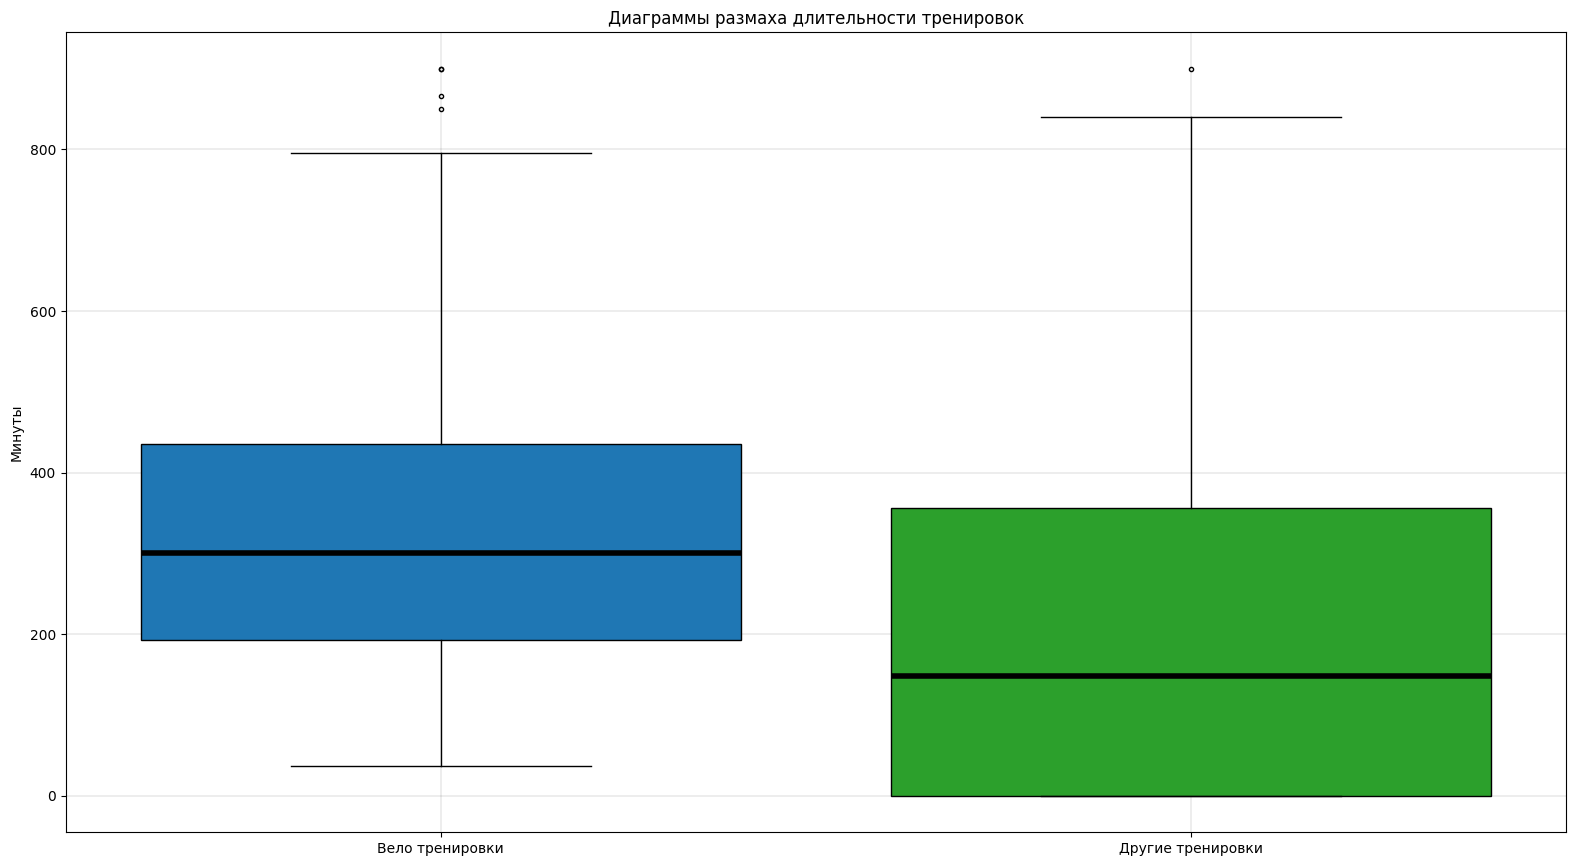

In [33]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(data['bike_minute'], positions=[0], labels = ['Вело тренировки'], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:blue'), medianprops=dict(color='black', linewidth=4))
ax.boxplot(data['train_minute'], positions=[1], labels = ['Другие тренировки'], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:green'), medianprops=dict(color='black', linewidth=4))

plt.title('Диаграммы размаха длительности тренировок')
plt.xlabel('')
plt.ylabel('Минуты')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

Закрашенная область - серединная половина, широкая "золотая середина". Толстая  черта в этой области - медиана. Кстати, она необязательно посередине закрашенной области. Верхний ус - граница в 97% спортсменов, нижний ус - 3%. Все что выше или ниже усов считается "выбросами/аномалиями" и обычно из данных для дальнейшего анализа удаляется.

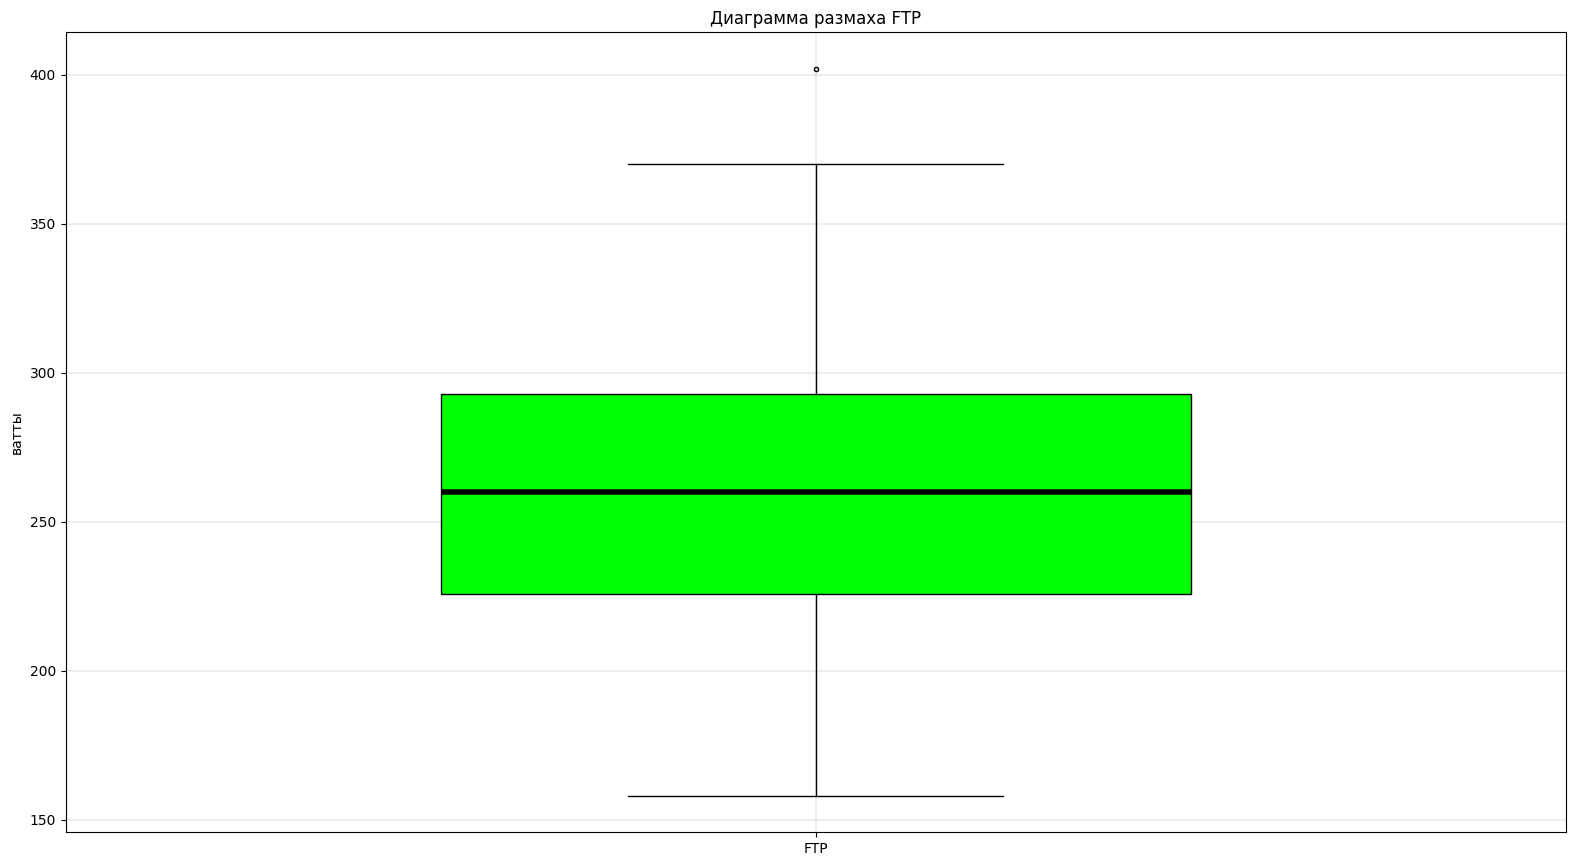

In [34]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])

ax.boxplot(data['ftp_c'], positions=[2], labels = ['FTP'], widths = 0.5 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='lime'), medianprops=dict(color='black', linewidth=4))
#ax.boxplot(data['weigth_c'], positions=[3], labels = ['Вес'], widths = 0.8 , sym = '.',\
#               patch_artist=True, boxprops=dict(facecolor='tab:pink'), medianprops=dict(color='black', linewidth=4))

plt.title('Диаграмма размаха FTP')
#plt.xlabel('FTP')
plt.ylabel('ватты')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

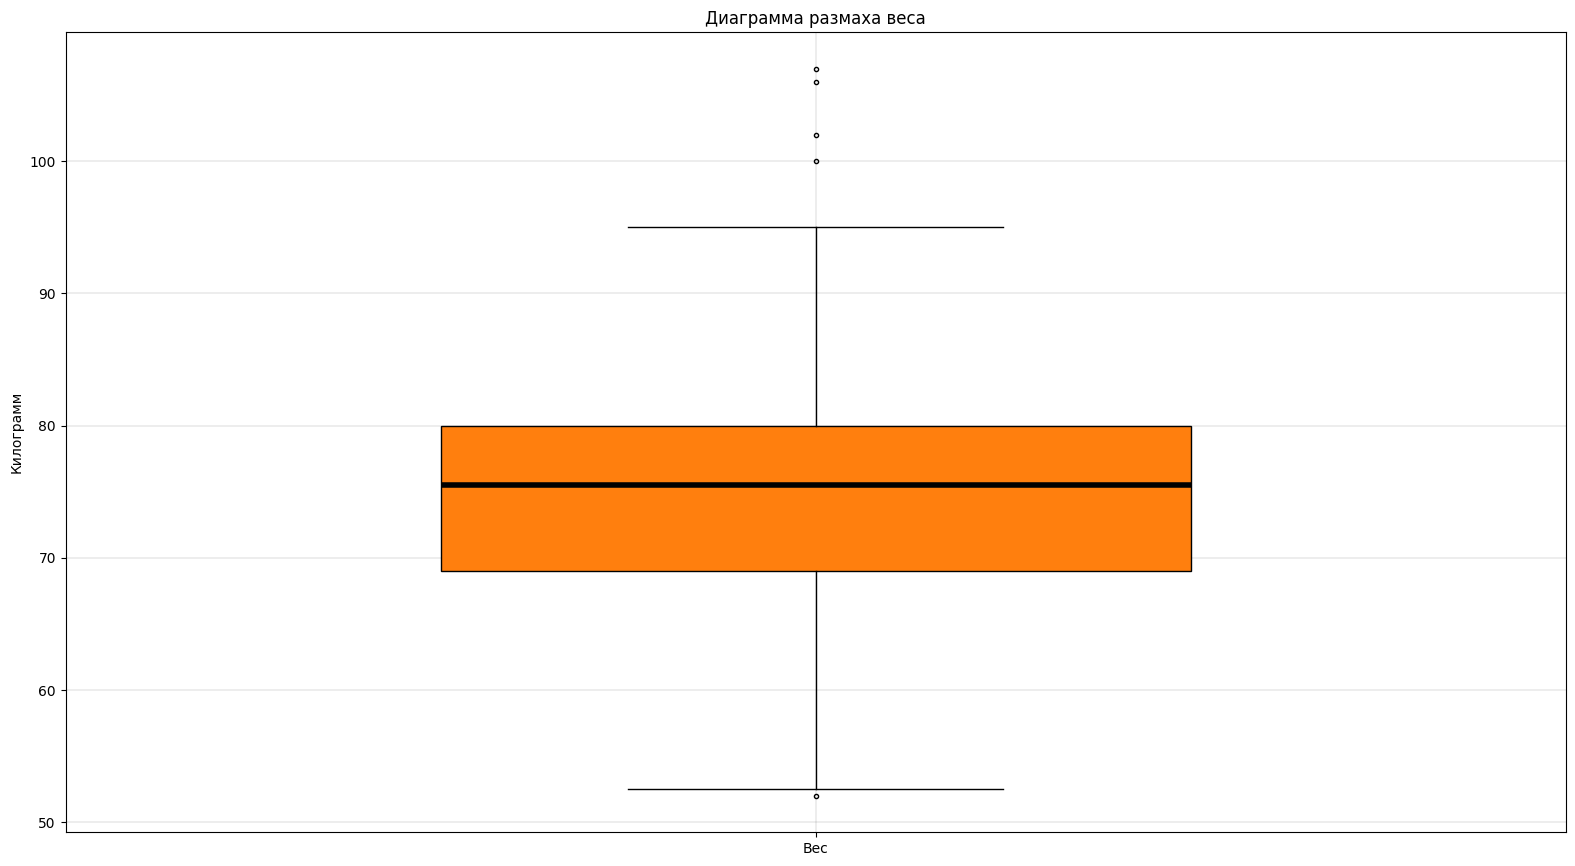

In [35]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])

ax.boxplot(data['weigth_c'], positions=[2], labels = ['Вес'], widths = 0.5 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:orange'), medianprops=dict(color='black', linewidth=4))
#ax.boxplot(data['weigth_c'], positions=[3], labels = ['Вес'], widths = 0.8 , sym = '.',\
#               patch_artist=True, boxprops=dict(facecolor='tab:pink'), medianprops=dict(color='black', linewidth=4))

plt.title('Диаграмма размаха веса')
plt.ylabel('Килограмм')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

## Корреляция FTP от тренировочных минут на вело

Шкала Чеддока для оценки корреляции:

- От 0 до 0,3 — очень слабая
- От 0,3 до 0,5 — слабая
- От 0,5 до 0,7 — средняя
- От 0,7 до 0,9 — сильная (высокая)
- От 0,9 до 1,0 — очень сильная (очень высокая)

Корреляция FTP и времени вело тренировок

In [36]:
data[['bike_minute', 'ftp_c']].corr(method='pearson')

,bike_minute,ftp_c
bike_minute,1.000000,0.490684
ftp_c,0.490684,1.000000


Корреляция FTP и веса спортсмена

In [37]:
data[['weigth_c', 'ftp_c']].corr(method='pearson')

,weigth_c,ftp_c
weigth_c,1.000000,0.350184
ftp_c,0.350184,1.000000


Корреляции FTP в ваттах и ватт/кг

In [38]:
data[['ftp_weigth', 'ftp_c']].corr(method='pearson')

,ftp_weigth,ftp_c
ftp_weigth,1.000000,0.727986
ftp_c,0.727986,1.000000


## Диаграммы рассеяния FTP и длительности тренировок


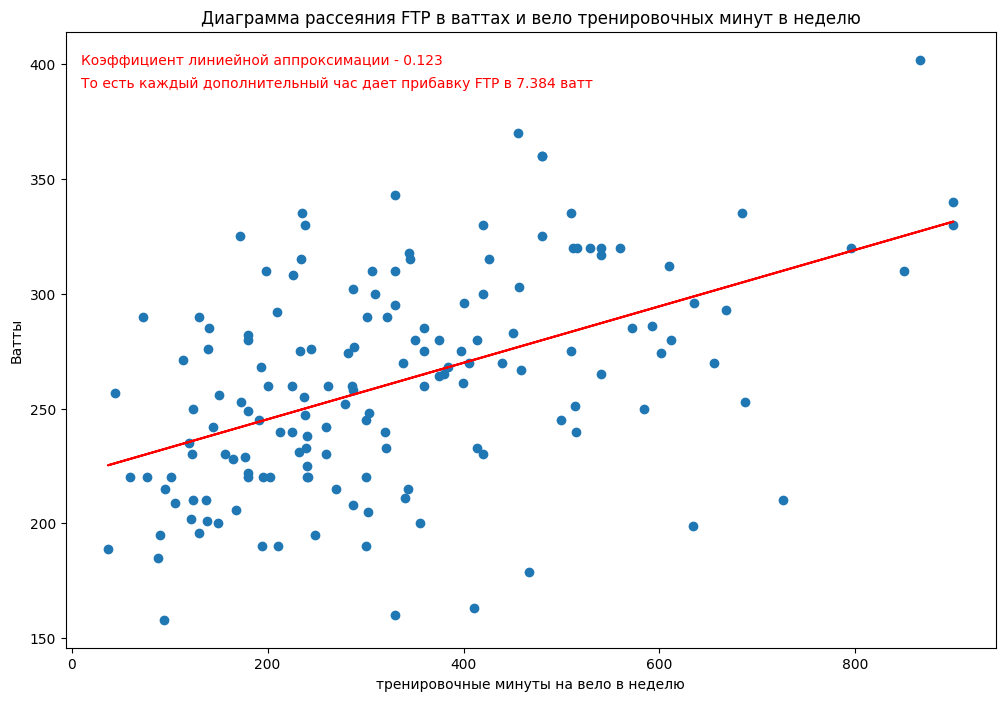

In [39]:
plt.figure(figsize=(12,8))
plt.scatter(data['bike_minute'], data['ftp_c'])

z = np.polyfit(data['bike_minute'], data['ftp_c'], 1)
p = np.poly1d(z)
plt.plot(data['bike_minute'], p(data['bike_minute']), color='red')

plt.text(10, 400, f'Коэффициент линиейной аппроксимации - {round(z[0], 3)}', color= 'red')
plt.text(10, 390, f'То есть каждый дополнительный час дает прибавку FTP в {round(z[0] * 60, 3)} ватт', color= 'red')
plt.title('Диаграмма рассеяния FTP в ваттах и вело тренировочных минут в неделю')
plt.ylabel('Ватты')
plt.xlabel('тренировочные минуты на вело в неделю')
plt.show()

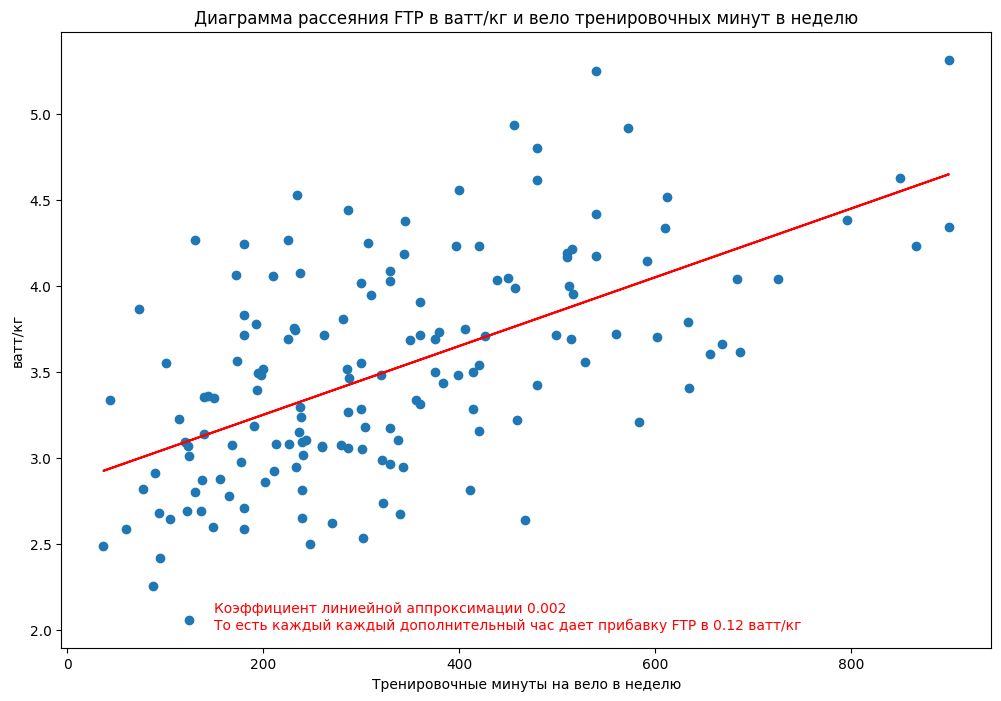

In [40]:
plt.figure(figsize=(12,8))
plt.scatter(data['bike_minute'], data['ftp_weigth'])

z = np.polyfit(data['bike_minute'], data['ftp_weigth'], 1)
p = np.poly1d(z)
plt.plot(data['bike_minute'], p(data['bike_minute']), color='red')

plt.text(150, 2.1, f'Коэффициент линиейной аппроксимации {round(z[0], 3)}', color= 'red')
plt.text(150, 2, f'То есть каждый каждый дополнительный час дает прибавку FTP в {round(z[0]*60, 3)} ватт/кг', color= 'red')
plt.title('Диаграмма рассеяния FTP в ватт/кг и вело тренировочных минут в неделю')
plt.ylabel('ватт/кг')
plt.xlabel('Тренировочные минуты на вело в неделю')
plt.show()

## Когортный анализ

Разделим спортменов на когорты **по завяленным FTP** - от 170 до 350+ с шагом в 20 ватт

In [41]:
ftp_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
qstr_last = ''
ftpbox = dict()
for i in range(170, 370, 20):
    qstr = qstr_last + 'ftp_c <= ' + str(i)
    #print(qstr)
    ftpbox[i]= data.query(qstr)['bike_minute']
    ftp_describe.loc[i] = ftpbox[i].describe()
    qstr_last =  str(i) + ' < '
ftpbox[999]= data.query('350 < ftp_c')['bike_minute']
ftp_describe.loc[999] = ftpbox[999].describe()

`Таблица статиcтичеcких характеристик когорт. Индекс - верхняя граница когорты`

In [42]:
ftp_describe

,count,mean,std,min,25%,50%,75%,max
170,3.0,278.333333,164.694667,94.0,212.0,330.0,370.50,411.0
190,6.0,216.166667,154.266544,37.0,114.5,202.5,277.75,467.0
210,15.0,247.733333,193.610606,90.0,127.0,149.0,294.50,726.0
230,21.0,207.857143,93.951203,60.0,156.0,195.0,260.00,420.0
250,20.0,283.150000,129.621422,120.0,207.5,239.5,320.25,584.0
270,24.0,344.708333,155.919567,44.0,234.0,349.0,414.25,687.0
290,25.0,328.808000,162.690673,73.0,180.0,322.0,414.00,612.0
310,14.0,402.000000,192.081713,198.0,292.0,330.0,447.75,850.0
330,17.0,480.117647,188.523501,172.0,345.0,512.0,540.00,900.0
350,5.0,531.800000,268.339710,235.0,330.0,510.0,684.00,900.0


Диаграммы размаха когорт

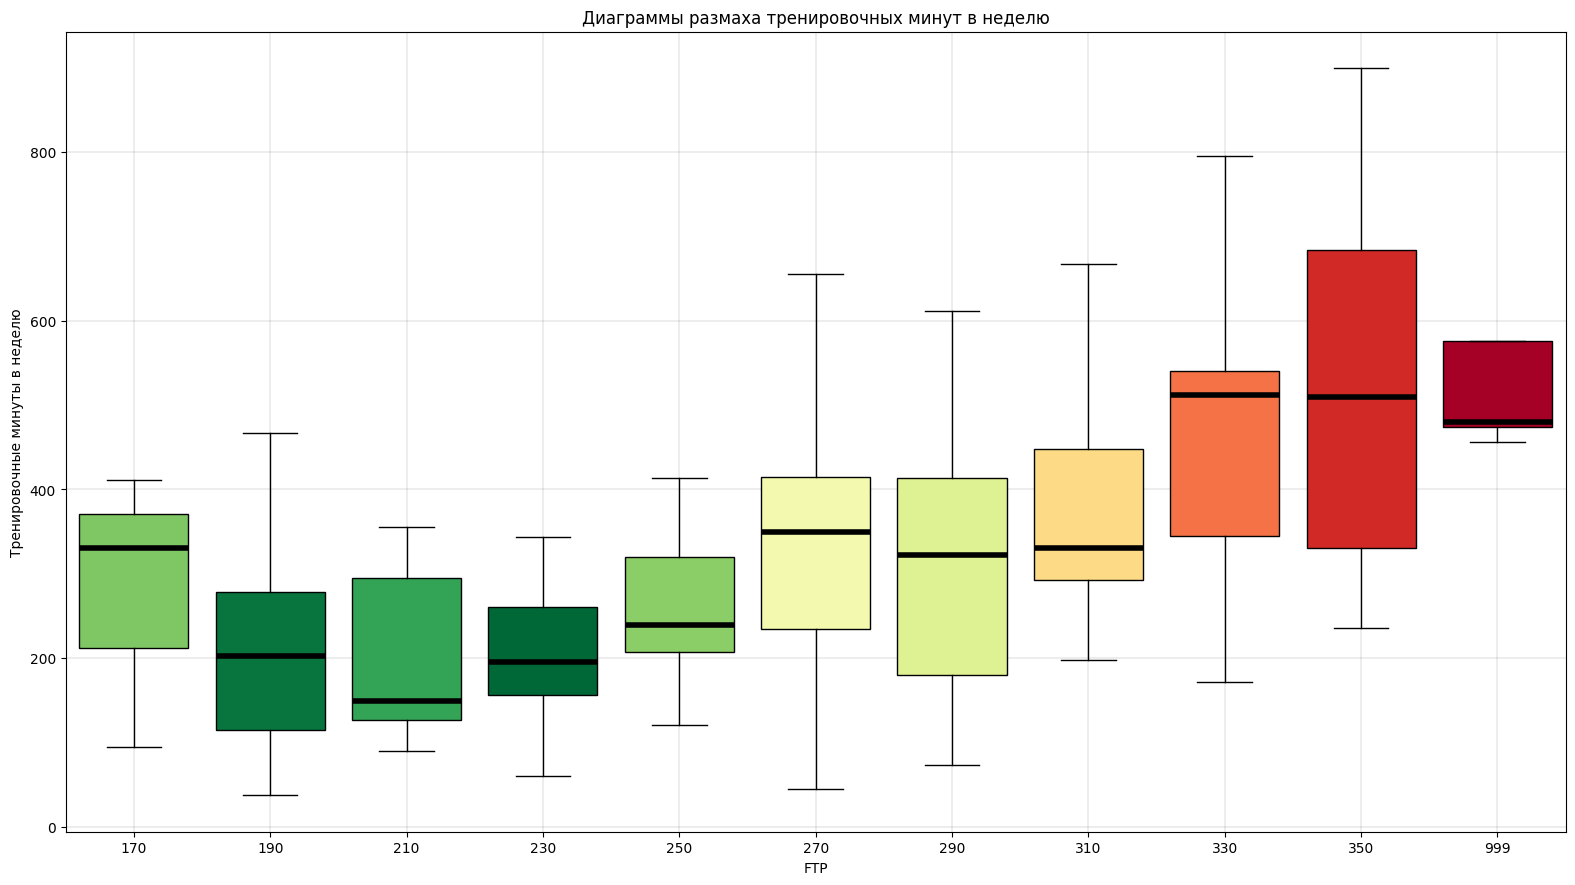

In [43]:
c = gradient_by_value(ftp_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for fb in ftpbox:
    ax.boxplot(ftpbox[fb], positions=[i], labels = [fb], widths = 0.8 , sym = '',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
plt.title('Диаграммы размаха тренировочных минут в неделю')
plt.xlabel('FTP')
plt.ylabel('Тренировочные минуты в неделю')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

Разделим спортменов на когорты **по длительности вело тренировок** в минутах - от 60 до 600+ с шагом в 60

In [44]:
bikeminut_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))

qstr_last = ''
bikeminutbox = dict()
for i in range(60, 610, 60):
    qstr = qstr_last + 'bike_minute <= ' + str(i)
    #print(qstr)
    bikeminutbox[i] = data.query(qstr)['ftp_c']
    qstr_last =  str(i) + ' < '
    bikeminut_describe.loc[i] = bikeminutbox[i].describe()
bikeminutbox[999]= data.query('600 < bike_minute')['ftp_c']
bikeminut_describe.loc[999] = bikeminutbox[999].describe()

`Таблица статиcтичеcких характеристик когорт. Индекс - верхняя граница когорты`

In [45]:
bikeminut_describe

,count,mean,std,min,25%,50%,75%,max
60,3.0,222.000000,34.044089,189.0,204.50,220.0,238.50,257.0
120,10.0,219.800000,38.823819,158.0,198.50,217.5,231.25,290.0
180,24.0,240.500000,34.678649,196.0,210.00,230.0,261.00,325.0
240,24.0,256.125000,40.862774,190.0,229.50,246.0,279.25,335.0
300,17.0,242.588235,31.545718,190.0,220.00,245.0,260.00,302.0
360,22.0,266.045455,46.686877,160.0,234.75,277.5,298.75,343.0
420,14.0,265.357143,38.891579,163.0,261.75,269.0,280.00,330.0
480,10.0,303.200000,57.518693,179.0,273.25,309.0,351.25,370.0
540,11.0,291.636364,36.360068,240.0,258.00,317.0,320.00,335.0
600,4.0,285.250000,28.581754,250.0,276.25,285.5,294.50,320.0


Диаграммы размаха когорт

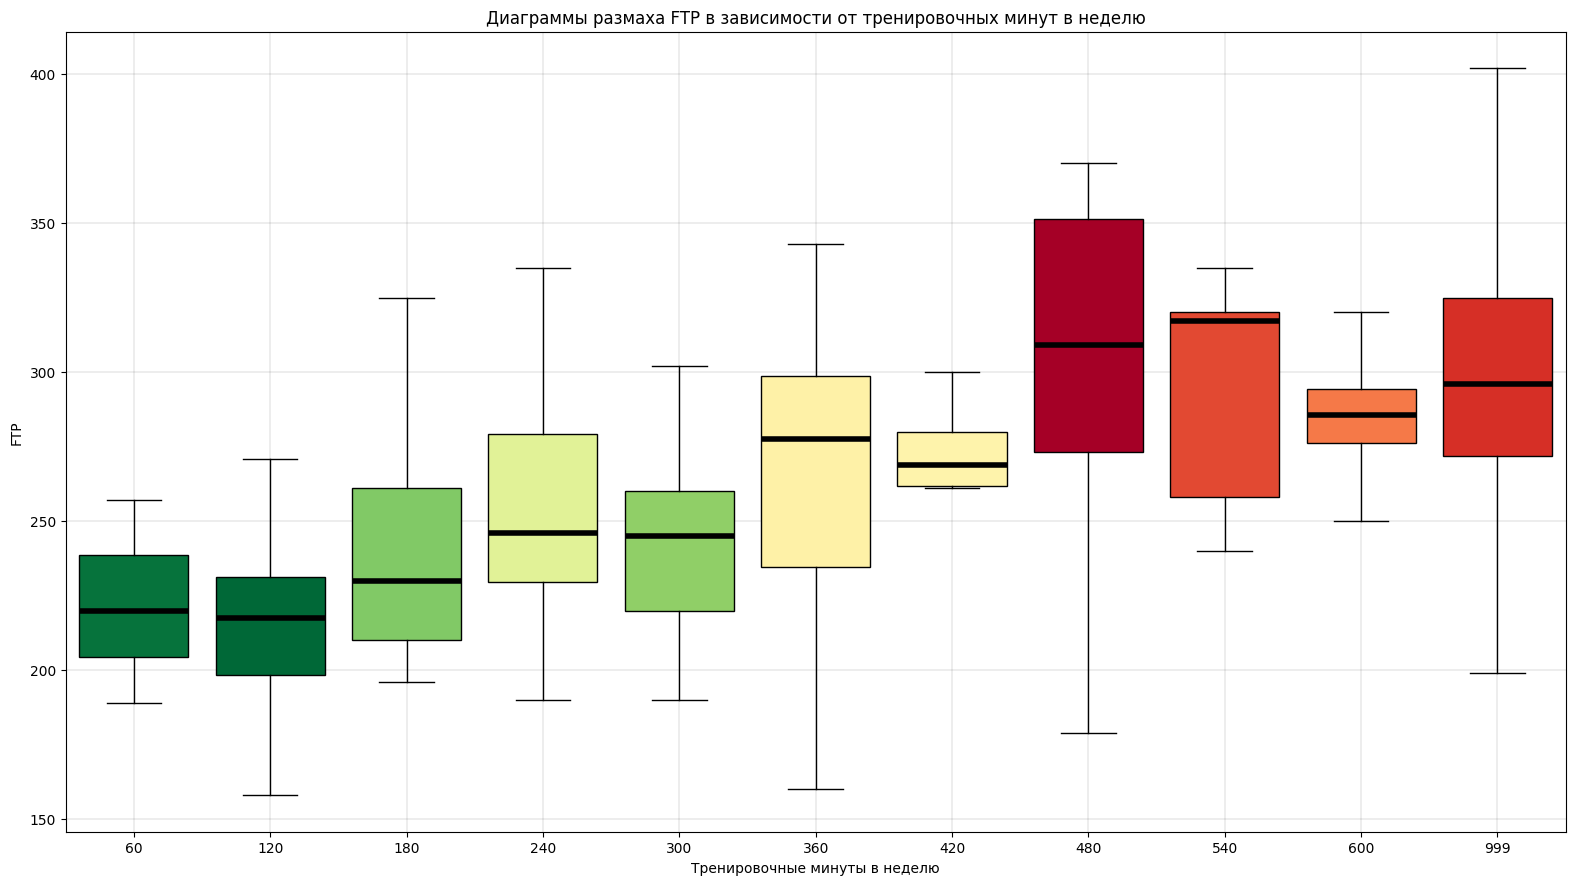

In [46]:
c = gradient_by_value(bikeminut_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in bikeminutbox:
    ax.boxplot(bikeminutbox[bk], positions=[i], labels = [bk], widths = 0.8 , sym = '',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
plt.title('Диаграммы размаха FTP в зависимости от тренировочных минут в неделю')
plt.xlabel('Тренировочные минуты в неделю')
plt.ylabel('FTP')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

Графики средних и медианных FTP в зависимости от когорты спортменов по тренировочным минутам

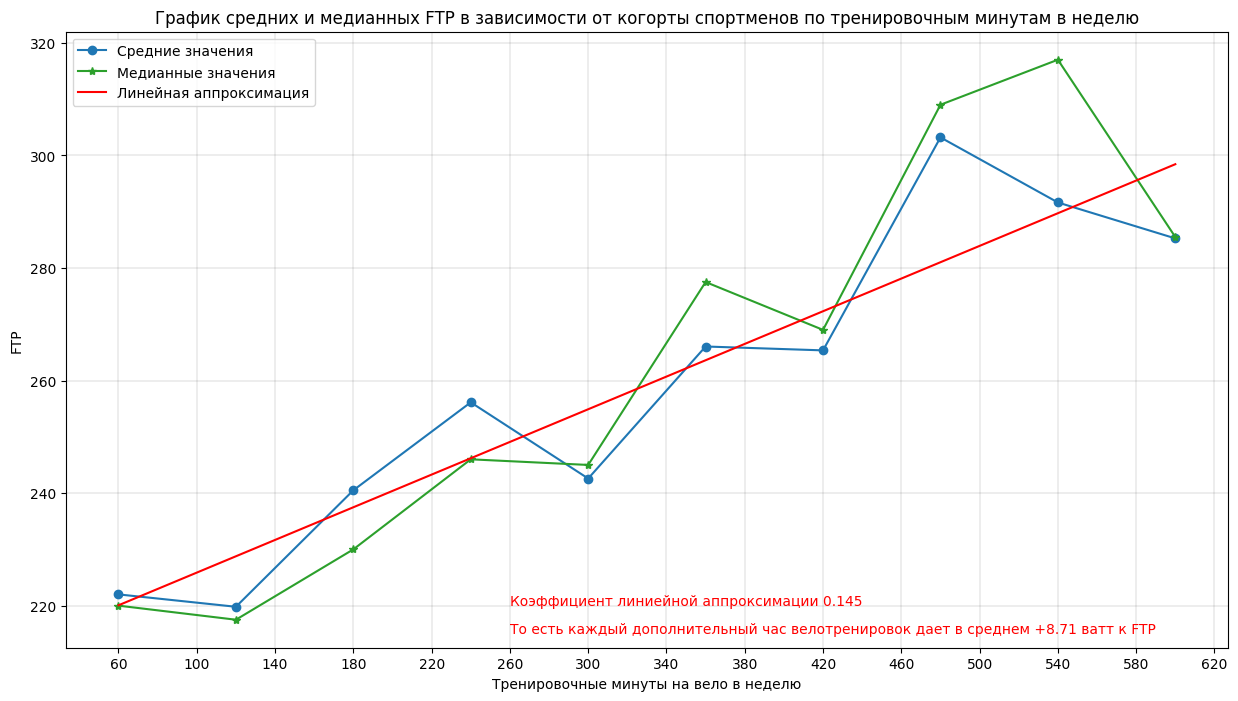

In [47]:
fig = plt.figure(figsize = (15, 8))
plt.plot(bikeminut_describe.index[0:-1], bikeminut_describe['mean'][0:-1], marker="o", color='tab:blue', label = 'Средние значения')
plt.plot(bikeminut_describe.index[0:-1], bikeminut_describe['50%'][0:-1], marker="*", color='tab:green', label = 'Медианные значения')

z = np.polyfit(bikeminut_describe.index[0:-1], bikeminut_describe['mean'][0:-1], 1)
p = np.poly1d(z)
plt.plot(bikeminut_describe.index[0:-1], p(bikeminut_describe.index[0:-1]), color='red', label = 'Линейная аппроксимация')
plt.text(260, 220, f'Коэффициент линиейной аппроксимации {round(z[0], 3)}', color= 'red')
plt.text(260, 215, f'То есть каждый дополнительный час велотренировок дает в среднем +{round(z[0]*60, 2)} ватт к FTP', color= 'red')


plt.title('График средних и медианных FTP в зависимости от когорты спортменов по тренировочным минутам в неделю')
plt.xlabel('Тренировочные минуты на вело в неделю')
plt.ylabel('FTP')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.xticks(np.linspace(60, 620, 15))
plt.show()

Интересно, что FTP с увеличением длительности тренировок по когортам растет не монотонно!

Заметны некие периодические колебания, которые пораждают локальные минимумы. Возможно, это методическая ошибка. Но также это можно интерпретировать как неоптимальный объем тренировок: завышение объема, которое не дает прироста FTP, а скорее наоборот! Спортсменая "в яммах" можно чуть уменьшить объем, и тогда их FTP вырастет.

Инетересно, что этот эффект наблюдается на всем дипазоне тренировочных объемов.

## Сравнение тренировок у велосипедистов и триатлетов

In [48]:
velo_only = data[data['train_minute'] < 10].copy()
velo_plus = data[data['train_minute'] > 0].copy()
velo_plus['all_minute'] = velo_plus['bike_minute'] + velo_plus['train_minute']

Проверка на аномалии

In [49]:
velo_plus.query('all_minute > 1200')

,date_answer,weigth,gender,sport,bike_hours,train_hours,train_stag,ftp,ftp_source,bike_minute,train_minute,weigth_c,ftp_c,ftp_weigth,all_minute
107,2024-12-26 17:24:16.300,76,Мужской,Велоспорт,15,15,30,330,Расчетным путем исходя их результатов гонок,900.0,900.0,76.0,330.0,4.342105,1800.0


In [50]:
#velo_plus.loc[107, 'all_minute'] = 0
#velo_plus.loc[107, 'train_minute'] = 0
velo_plus = velo_plus.drop(index = 107)

Диаграммы рассеяния FTP и длительности тренировок

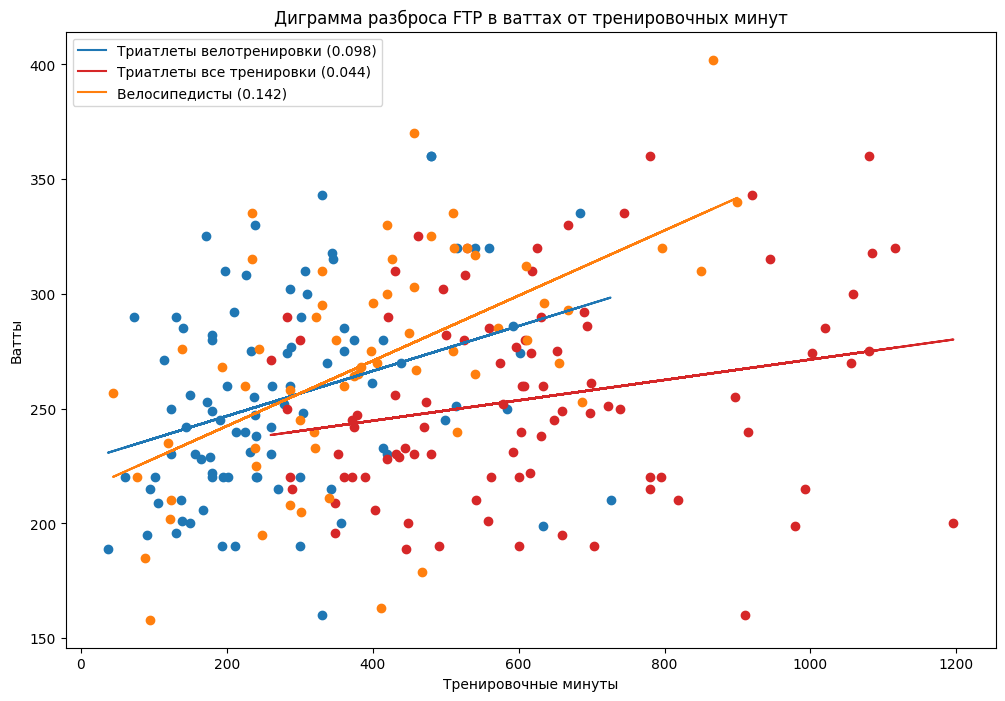

In [51]:
plt.figure(figsize=(12,8))
plt.scatter(velo_plus['bike_minute'], velo_plus['ftp_c'], color='tab:blue')
z = np.polyfit(velo_plus['bike_minute'], velo_plus['ftp_c'], 1)
p = np.poly1d(z)
l = f'Триатлеты велотренировки ({round(z[0], 3)})'
plt.plot(velo_plus['bike_minute'], p(velo_plus['bike_minute']), color='tab:blue', label = l)

plt.scatter(velo_plus['all_minute'], velo_plus['ftp_c'], color='tab:red')
z = np.polyfit(velo_plus['all_minute'], velo_plus['ftp_c'], 1)
p = np.poly1d(z)
l = f'Триатлеты все тренировки ({round(z[0], 3)})'
plt.plot(velo_plus['all_minute'], p(velo_plus['all_minute']), color='tab:red', label = l)


plt.scatter(velo_only['bike_minute'], velo_only['ftp_c'], color='tab:orange')
z = np.polyfit(velo_only['bike_minute'], velo_only['ftp_c'], 1)
p = np.poly1d(z)
l = f'Велосипедисты ({round(z[0], 3)})'
plt.plot(velo_only['bike_minute'], p(velo_only['bike_minute']), color='tab:orange', label = l)

plt.title('Диграмма разброса FTP в ваттах от тренировочных минут')
plt.ylabel('Ватты')
plt.xlabel('Тренировочные минуты')
plt.legend()
plt.show()

Статистические характеристики велосипедистов

In [52]:
velo_only[['ftp_c', 'bike_minute']].rename(columns = {'ftp_c' : 'FTP', 'bike_minute' : 'Веломинуты'}).describe().T

,count,mean,std,min,25%,50%,75%,max
FTP,62.0,270.822581,49.324461,158.0,240.00,272.5,308.25,402.0
Веломинуты,62.0,400.180645,197.631244,44.0,257.75,390.5,511.50,900.0


Статистические характеристики триатлетов

In [53]:
velo_plus[['ftp_c', 'bike_minute', 'all_minute']].rename(columns = {'ftp_c' : 'FTP', 'bike_minute' : 'Веломинуты', 'all_minute' : 'Все тренировки'}).describe().T

,count,mean,std,min,25%,50%,75%,max
FTP,91.0,254.494505,43.362906,160.0,220.0,250.0,283.5,360.0
Веломинуты,91.0,279.000000,150.265173,37.0,175.0,240.0,344.5,726.0
Все тренировки,91.0,620.406593,227.829223,260.0,444.5,600.0,730.5,1196.0


Доля велотренировок у триатетов

In [54]:
velo_plus[velo_plus['all_minute'] == 0]

,date_answer,weigth,gender,sport,bike_hours,train_hours,train_stag,ftp,ftp_source,bike_minute,train_minute,weigth_c,ftp_c,ftp_weigth,all_minute


In [55]:
velo_plus['train_prob'] = round(100 * velo_plus['bike_minute'] / velo_plus['all_minute'], 2)
print(f"Средняя доля велотренировок у триатлетов - {round(velo_plus['train_prob'].mean(), 2)}%")

Средняя доля велотренировок у триатлетов - 45.81%


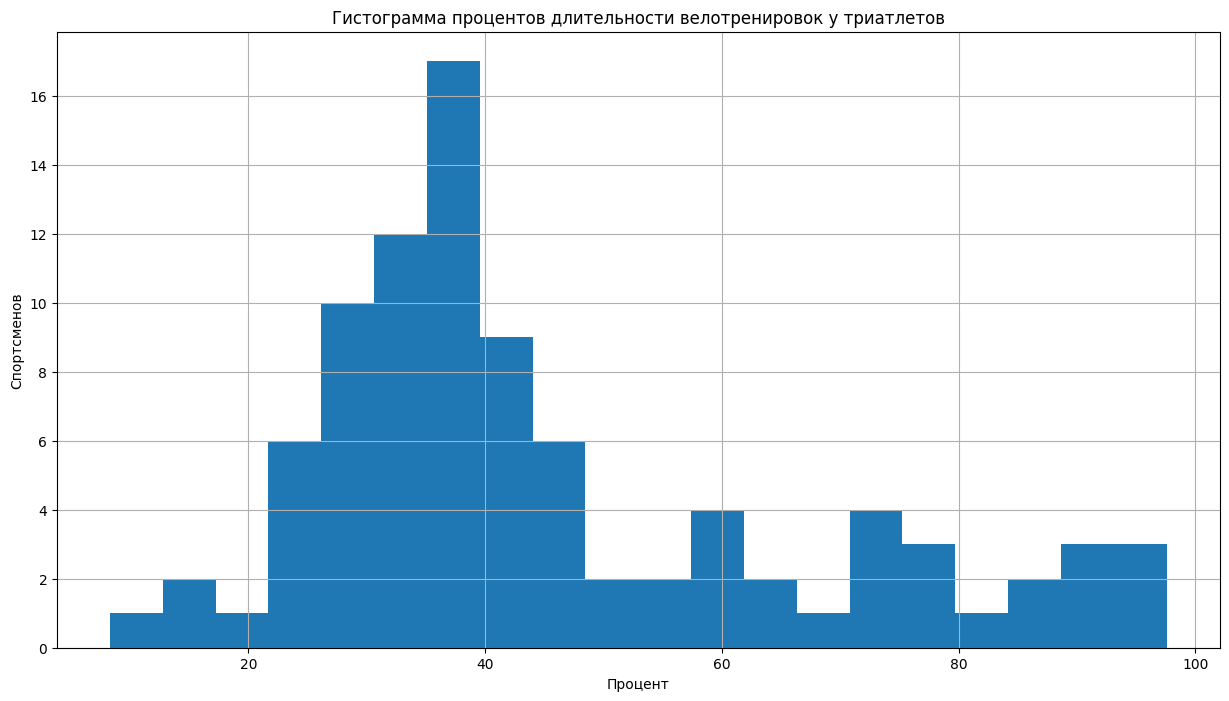

In [56]:
plt.figure(figsize=(15,8))

velo_plus['train_prob'].hist(bins = 20, alpha = 1, color = 'tab:blue', label = 'Триатлеты')
plt.title('Гистограмма процентов длительности велотренировок у триатлетов')
plt.ylabel('Спортсменов')
plt.xlabel('Процент')
#plt.legend()
plt.show()

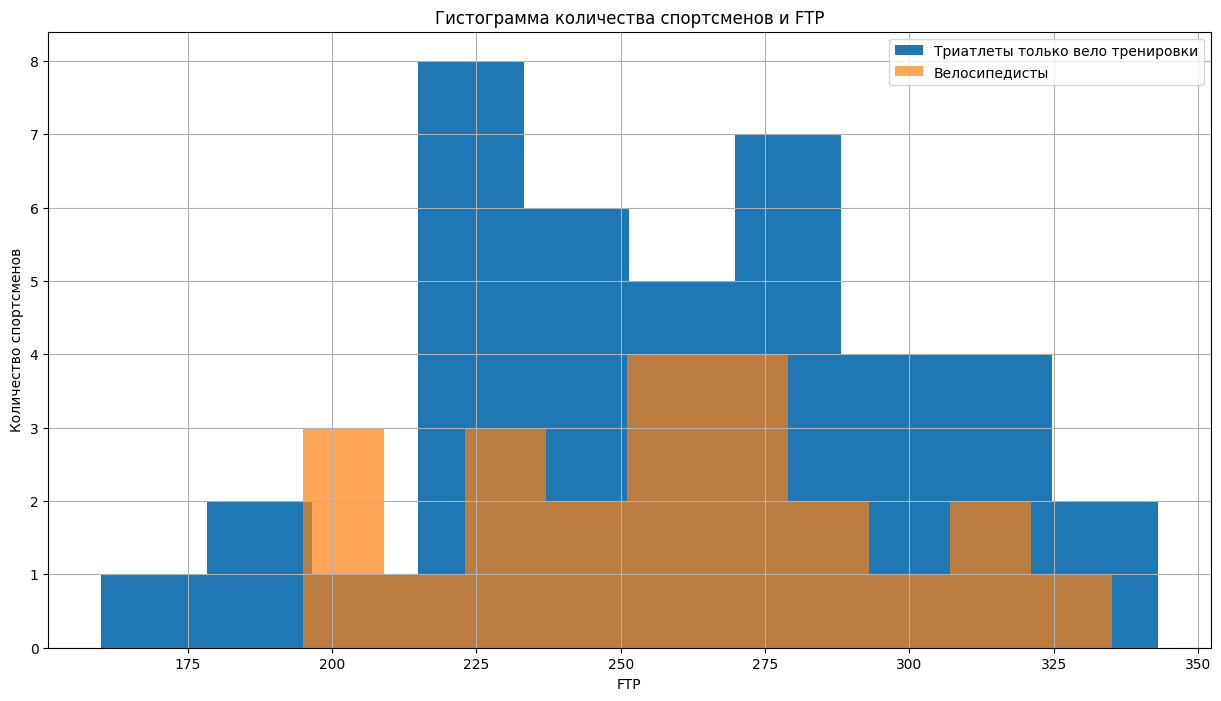

In [57]:
plt.figure(figsize=(15,8))

velo_plus.query('bike_minute > 200 & bike_minute < 400')['ftp_c'].hist(bins = 10, alpha = 1, color = 'tab:blue', label = 'Триатлеты только вело тренировки')
velo_only.query('bike_minute > 200 & bike_minute < 400')['ftp_c'].hist(bins = 10, alpha = 0.7,  color = 'tab:orange', label = 'Велосипедисты')
plt.title('Гистограмма количества спортсменов и FTP')
plt.ylabel('Количество спортсменов')
plt.xlabel('FTP')
plt.legend()
plt.show()

## Статистическая проверка гипотез

Проверим гипотезу, что при сопоставимом объеме только велотренировок у велоиспедистов и триатлетов, у первых будет выше FTP.

Вторая гипотеза: при сопоставимом FTP у велосипедистов и триатлетов у первых будет больше только велотренировок.

Третья гипотеза: при сопоставимом FTP у велосипедистов и триатлетов у последних общий объем всех тренировок будет больше, чем веломинут у велосипедистов

Проверку гипотез проведем только на спортсменах из середенной половины. Для этого возьмем границы из "золотой середины" статистических характетистик FTP и длительности тренировок

In [58]:
ftp_gold_min = train_stat.loc['FTP', '25%']
ftp_gold_max = train_stat.loc['FTP', '75%']
bikeminute_gold_min = train_stat.loc['Вело тренировки', '25%']
bikeminute_gold_max = train_stat.loc['Вело тренировки', '75%']
allminute_gold_min = velo_plus['all_minute'].describe().loc['25%']
allminute_gold_max = velo_plus['all_minute'].describe().loc['75%']

In [59]:
print(f"Границы серединной половины по FTP {ftp_gold_min} - {ftp_gold_max}")
print(f"Границы серединной половины по веломинутам {bikeminute_gold_min} - {bikeminute_gold_max}")
print(f"Границы серединной половины по минутам всех тренировок {allminute_gold_min} - {allminute_gold_max}")

Границы серединной половины по FTP 225.75 - 292.75
Границы серединной половины по веломинутам 193.25 - 435.75
Границы серединной половины по минутам всех тренировок 444.5 - 730.5


In [60]:
velo_compare = pd.DataFrame(columns = ('FTP', 'train_duration'))
velo_compare.loc['велосипедисты','FTP'] = round(velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].mean(), 2)
velo_compare.loc['триатлеты только вело','FTP'] = round(velo_plus.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].mean(), 2)
velo_compare.loc['триатлеты все тренировки','FTP'] = round(velo_plus.query('all_minute > @allminute_gold_min & all_minute < @allminute_gold_max')['ftp_c'].mean(), 2)


In [61]:
print(f"Средний FTP велосипедистов из золотой середины по длительности велотренировок - {velo_compare.loc['велосипедисты', 'FTP']} ватт")
print(f"Средний FTP триатлетов из золотой середины по длительности велотренировок - {velo_compare.loc['триатлеты только вело', 'FTP']} ватт")
print(f"Средний FTP триатлетов из золотой середины по длительности всех тренировок - {velo_compare.loc['триатлеты все тренировки', 'FTP']} ватт")

Средний FTP велосипедистов из золотой середины по длительности велотренировок - 262.76 ватт
Средний FTP триатлетов из золотой середины по длительности велотренировок - 255.77 ватт
Средний FTP триатлетов из золотой середины по длительности всех тренировок - 255.18 ватт


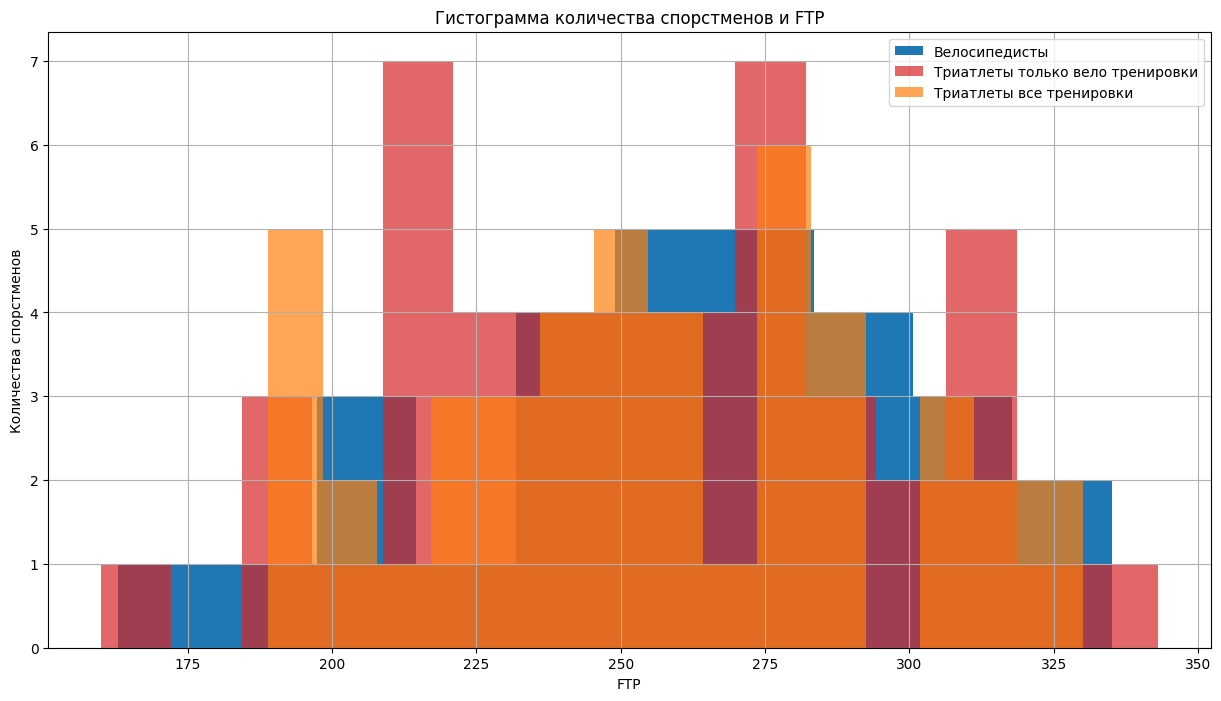

In [62]:
plt.figure(figsize=(15,8))

velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].hist(bins = 10, alpha = 1, color = 'tab:blue', label = 'Велосипедисты')
velo_plus.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].hist(bins = 15, alpha = 0.7, color = 'tab:red', label = 'Триатлеты только вело тренировки')
velo_plus.query('all_minute > @allminute_gold_min & all_minute < @allminute_gold_max')['ftp_c'].hist(bins = 15, alpha = 0.7,  color = 'tab:orange', label = 'Триатлеты все тренировки')
plt.title('Гистограмма количества спорстменов и FTP')
plt.ylabel('Количества спорстменов')
plt.xlabel('FTP')
plt.legend()
plt.show()

In [63]:
test_selection(velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'],
               velo_plus.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'],
               side='greater',
               h0 = 'Велосипедисты и триатлеты из "золотой середины" по длительности велотренировок имеют одинаковые FTP',
               h1 = 'У велосипедистов из "золотой середины" по длительности велотренировок FTP больше',
               )

Первая выборка размером 29 прошла проверку на нормальное распределение. pval = 0.6878207175547371
Вторая выборка размером 47 прошла проверку на нормальное распределение. pval = 0.8050217137364017
Дисперсии выборок близки. pval = 0.8932213422240983. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!

--- Проводим TTest ---
В результате теста получено p-value 0.23947760666770368
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и триатлеты из "золотой середины" по длительности велотренировок имеют одинаковые FTP 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.2111675067311612
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и триатлеты из "золотой середины" по длительности велотренировок имеют одинаковые FTP 


In [64]:
test_selection(velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'],
               velo_plus.query('all_minute > @allminute_gold_min & all_minute < @allminute_gold_max')['ftp_c'],
               side='greater',
               h0 = 'Велосипедисты и триатлеты из "золотой середины" по длительности велотренировок имеют одинаковые FTP',
               h1 = 'У велосипедистов из "золотой середины" по длительности велотренировок FTP больше',
               )

Первая выборка размером 29 прошла проверку на нормальное распределение. pval = 0.6878207175547371
Вторая выборка размером 45 прошла проверку на нормальное распределение. pval = 0.2973327138899947
Дисперсии выборок близки. pval = 0.9445386105540415. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!

--- Проводим TTest ---
В результате теста получено p-value 0.21896407582995098
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и триатлеты из "золотой середины" по длительности велотренировок имеют одинаковые FTP 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.18778518887148754
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и триатлеты из "золотой середины" по длительности велотренировок имеют одинаковые FTP 


То есть велосипедисты и триатлеты по показателю FTP как часовой максимальной мощности - сопоставимы / равны / одинаковы

In [65]:
velo_compare.loc['велосипедисты','train_duration'] = round(velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].mean(), 2)
velo_compare.loc['триатлеты только вело','train_duration'] = round(velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].mean(), 2)
velo_compare.loc['триатлеты все тренировки','train_duration'] = round(velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['all_minute'].mean(), 2)

In [66]:
print(f"Средняя длительность велотренировок велосипедистов из золотой середины FTP - {velo_compare.loc['велосипедисты','train_duration']} минут")
print(f"Средняя длительность велотренировок триатлетов из золотой середины FTP - {velo_compare.loc['триатлеты только вело','train_duration']} минут")
print(f"Средняя длительность всех тренировок триатлетов из золотой середины FTP - {velo_compare.loc['триатлеты все тренировки','train_duration']} минут")

Средняя длительность велотренировок велосипедистов из золотой середины FTP - 371.69 минут
Средняя длительность велотренировок триатлетов из золотой середины FTP - 276.25 минут
Средняя длительность всех тренировок триатлетов из золотой середины FTP - 585.4 минут


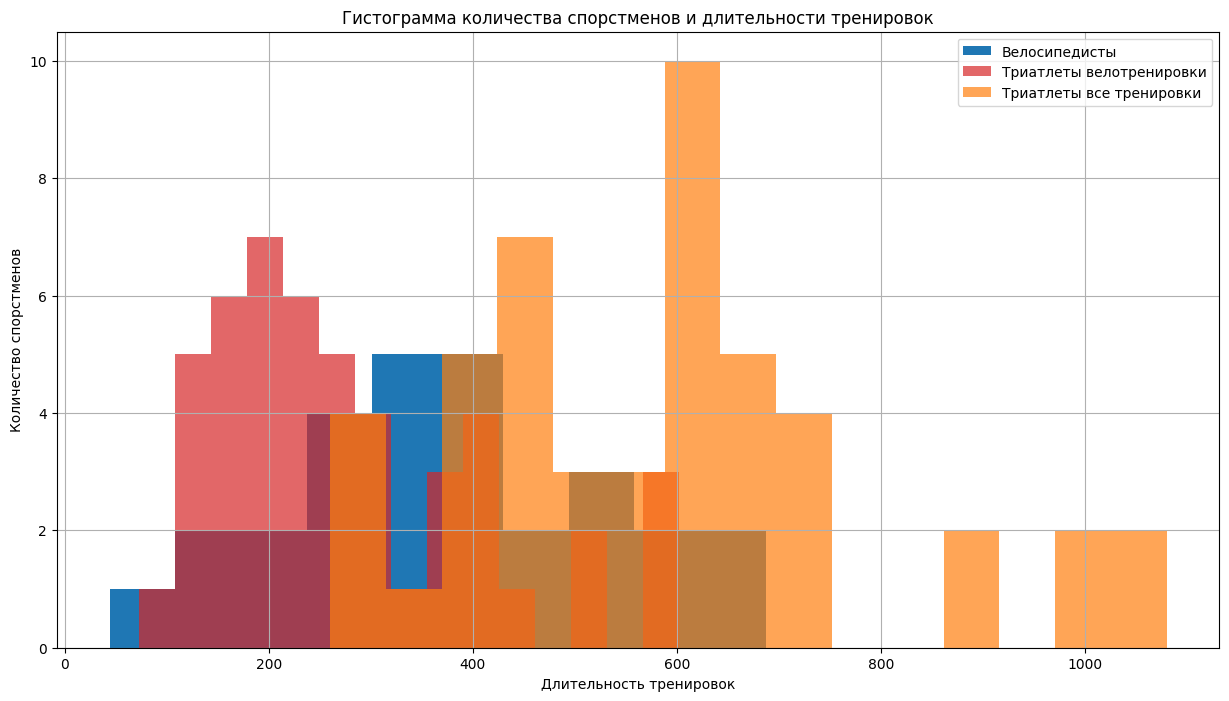

In [67]:
plt.figure(figsize=(15,8))

velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].hist(bins = 10, alpha = 1, color = 'tab:blue', label = 'Велосипедисты')
velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].hist(bins = 15, alpha = 0.7, color = 'tab:red', label = 'Триатлеты велотренировки')
velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['all_minute'].hist(bins = 15, alpha = 0.7,  color = 'tab:orange', label = 'Триатлеты все тренировки')
plt.title('Гистограмма количества спорстменов и длительности тренировок')
plt.ylabel('Количество спорстменов')
plt.xlabel('Длительность тренировок')
plt.legend()
plt.show()

In [68]:
test_selection(velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'],
               velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'],
               side='greater',
               h0 = 'Велосипедисты и триатлеты из "золотой середины" по FTP имеют одинаковую длительность только велотренировок',
               h1 = 'У велосипедистов из "золотой середины" по FTP время велотренировок больше, чем у триатлетов',
               )

Первая выборка размером 28 прошла проверку на нормальное распределение. pval = 0.9561335290179035
Вторая выборка размером 48 НЕ прошла проверку на нормальное распределение. pval = 0.03665827450557067
Дисперсии выборок близки. pval = 0.3214507031890369. Применяем equal_var=True 


--- Проводим TTest ---
В результате теста получено p-value 0.0033104020002868075
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У велосипедистов из "золотой середины" по FTP время велотренировок больше, чем у триатлетов 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.0030649790931048674
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У велосипедистов из "золотой середины" по FTP время велотренировок больше, чем у триатлетов 


In [69]:
test_selection(velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['all_minute'],
               velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'],
               side='greater',
               h0 = 'Велосипедисты и триатлеты из "золотой середины" по FTP имеют одинаковую суммарную длительность ВСЕХ тренировок',
               h1 = 'У триатлетов из "золотой середины" по FTP длительность всех тренировок больше',
               )

Первая выборка размером 48 прошла проверку на нормальное распределение. pval = 0.08091797539340265
Вторая выборка размером 28 прошла проверку на нормальное распределение. pval = 0.9561335290179035
Дисперсии выборок близки. pval = 0.32999102638065736. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!

--- Проводим TTest ---
В результате теста получено p-value 4.258407855131907e-06
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У триатлетов из "золотой середины" по FTP длительность всех тренировок больше 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 9.323639820303249e-06
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У триатлетов из "золотой середины" по FTP длительность всех тренировок больше 


То есть у велосипедистов больше именно велотренировок, чем у триатлетов, но у триатлетов больше вообще тренировок, чем у велосипедистов. При этом FTP сопоставимы.


In [70]:
velo_compare.T

,велосипедисты,триатлеты только вело,триатлеты все тренировки
FTP,262.76,255.77,255.18
train_duration,371.69,276.25,585.4


In [71]:
print(f"У велосипедистов велотренировок больше, чем у триатлетов на {round(100 * (velo_compare.loc['велосипедисты', 'train_duration'] - velo_compare.loc['триатлеты только вело', 'train_duration']) / velo_compare.loc['триатлеты только вело', 'train_duration'], 2) } %")
print(f"У триатлетов всех тренировок больше, чем велотренировок у велосипедистов на {round(100 * (velo_compare.loc['триатлеты все тренировки', 'train_duration'] - velo_compare.loc['велосипедисты', 'train_duration']) / velo_compare.loc['велосипедисты', 'train_duration'], 2) } %")
print(f"При этому у велосипедистов FTP больше, чем у триатлетов на {round(100 * (velo_compare.loc['велосипедисты', 'FTP'] - velo_compare.loc['триатлеты все тренировки', 'FTP']) / velo_compare.loc['триатлеты все тренировки', 'FTP'], 2) } %")

У велосипедистов велотренировок больше, чем у триатлетов на 34.55 %
У триатлетов всех тренировок больше, чем у велотренировок у велосипедистов на 57.5 %
При этому у велосипедистов FTP больше, чем у триатлетов на 2.97 %


Встает вопрос: это триатлеты более эффективно тренируются именно на вело, или триатлеты добирают в других видах тренировок?